In [ ]:
!pip install xgboost catboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, classification_report,
    cohen_kappa_score
)
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Filter dataset attributes for the 6 datasets in excel then import
data = pd.read_csv('Master_Model_20_PC.csv')

# Drop unwanted features
X = data.drop(columns=['IndoorCount', 'OutdoorCount','time_to_adoption','age_category_at_listing'])  #Alternate for Count or Present
#X = data.drop(columns = ['SceneCategory','photo_n','age_category_at_listing','time_to_adoption'])
# 'time_to_adoption' is the target variable and the rest are features
y = data['time_to_adoption']

# Define the feature lists
binary_features = [
    'ToyPresent',
    'PersonPresent', 'CloseUp_Present', 'Middle_Present', 'Far_Present', 'Near_Present',
    'Web_Topic_0_Present', 'Web_Topic_1_Present', 'Web_Topic_2_Present', 'Web_Topic_3_Present',
    'Home_Topic_0_Present', 'Home_Topic_1_Present', 'Home_Topic_2_Present', 'Energetic/Extroverted',
    'Self-assured/Motivated','Responsiveness to training', 'Friendly/Sociable', 'Nervous/Sensitive'
]

nominal_categorical_features = [
    'sex', 'NewCol', 'Breed_Group', 'rehoming_centre', 'age_category_at_listing', 'SceneCategory',
    'Hair_Length', 'Tail', 'Size', 'Nuetered'
]

numerical_features = [
    'age_at_listing', 'webpage_views', 'web_token_count', 'home_token_count', 'web_lexical_density',
    'home_lexical_density', 'web_lexical_diversity', 'web_sentiment_score', 'home_lexical_diversity',
    'home_sentiment_score', 'Web_Topic_0', 'Web_Topic_1', 'Web_Topic_2', 'Web_Topic_3',
    'Home_Topic_0', 'Home_Topic_1', 'Home_Topic_2'
]

ordinal_categorical_features = [
    'PersonCount', 'IndoorCount', 'OutdoorCount', 'ToyCount',
    'CloseUp_Count', 'Middle_Count', 'Far_Count', 'Near_Count'
]

# Filter columns based on their presence in the DataFrame
existing_numerical_features = [col for col in numerical_features if col in X.columns]
existing_ordinal_categorical_features = [col for col in ordinal_categorical_features if col in X.columns]
existing_nominal_categorical_features = [col for col in nominal_categorical_features if col in X.columns]
existing_binary_features = [col for col in binary_features if col in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), existing_numerical_features),

        ('ord_cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
        ]), existing_ordinal_categorical_features),

        ('nom_cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False))
        ]), existing_nominal_categorical_features),

        ('binary', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), existing_binary_features)
    ],
    sparse_threshold=0
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize results storage
results = []
feature_importances = {}

# Define and train regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(200, 100, 50), max_iter=1500, random_state=42),
    "Poisson Regression": PoissonRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()  # Handle discrete targets effectively
}

for name, model in regression_models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Round predictions to get discrete values
    y_pred_discrete = np.round(y_pred).astype(int)
    mse_discrete = mean_squared_error(y_test, y_pred_discrete)
    r2_discrete = r2_score(y_test, y_pred_discrete)

    # Feature importance extraction
    if name in ["Random Forest Regressor", "Gradient Boosting Regressor"]:
        importance = model.feature_importances_
    elif name in ["Linear Regression", "Poisson Regression"]:
        importance = np.abs(model.coef_)
    elif name in ["MLP Regressor", "Support Vector Regressor"]:
        # Use the transformed data for permutation importance
        X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
        importance = permutation_importance(model, X_test_transformed, y_test, n_repeats=5, random_state=42).importances_mean

    # Normalize importance
    importance_normalized = importance / np.sum(importance)

    # Get feature names from the preprocessor
    transformer = pipeline.named_steps['preprocessor']
    num_features = transformer.transformers_[0][2]
    cat_features = transformer.transformers_[2][1].named_steps['onehot'].get_feature_names_out(existing_nominal_categorical_features).tolist()
    feature_names = num_features + cat_features + existing_ordinal_categorical_features + existing_binary_features

    # Check the length of feature_names and importance to avoid index errors
    if len(feature_names) != len(importance_normalized):
        print(f"Warning: The number of features ({len(feature_names)}) does not match the number of importances ({len(importance_normalized)}).")

    # Store the top 5 important features
    top_indices = np.argsort(importance_normalized)[-5:][::-1]
    top_features = [(feature_names[i], importance_normalized[i]) for i in top_indices]
    feature_importances[name] = top_features

    # Store the results with top features
    results.append({
        'Model': name,
        'Mean Squared Error (Continuous)': mse,
        'R^2 Score (Continuous)': r2,
        'Mean Squared Error (Discrete)': mse_discrete,
        'R^2 Score (Discrete)': r2_discrete,
        'Top 5 Features': [f'{feature}: {importance:.4f}' for feature, importance in top_features]
    })




# Classification task: ordinal
y = pd.cut(y, bins=[-float('inf'), 2, 5, 10, 20, float('inf')], labels=['0-1', '2-5', '5-10', '10-20', '20+'], right=False)
y = OrdinalEncoder().fit_transform(y.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Classifier": SVC(kernel='rbf', random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(200, 100, 50), max_iter=1500, random_state=42),
    "XGBoost Classifier": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "CatBoost Classifier": CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=0, random_state=42)
}

for name, model in classification_models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')

    # Feature importance extraction
    if name in ["Random Forest Classifier", "XGBoost Classifier", "CatBoost Classifier"]:
        importance = model.feature_importances_
    elif name in ["Logistic Regression"]:
        importance = np.abs(model.coef_[0])
    elif name in ["MLP Regressor", "Support Vector Regressor"]:
        # Use the transformed data for permutation importance
        X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
        importance = permutation_importance(model, X_test_transformed, y_test, n_repeats=10, random_state=42).importances_mean

    # Normalize importance
    importance_normalized = importance / np.sum(importance)

    # Get feature names from the preprocessor
    transformer = pipeline.named_steps['preprocessor']
    num_features = transformer.transformers_[0][2]
    cat_features = transformer.transformers_[2][1].named_steps['onehot'].get_feature_names_out(existing_nominal_categorical_features).tolist()
    feature_names = num_features + cat_features + existing_ordinal_categorical_features + existing_binary_features

    # Check the length of feature_names and importance to avoid index errors
    if len(feature_names) != len(importance_normalized):
        print(f"Warning: The number of features ({len(feature_names)}) does not match the number of importances ({len(importance_normalized)}).")

    # Store the top 5 important features
    top_indices = np.argsort(importance_normalized)[-5:][::-1]
    top_features = [(feature_names[i], importance_normalized[i]) for i in top_indices]
    feature_importances[name] = top_features

    # Store the results with top features
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Quadratic Weighted Kappa': qwk,
        'Top 5 Features': [f'{feature}: {importance:.4f}' for feature, importance in top_features]
    })

results_df = pd.DataFrame(results)

# Initialize an empty list to store feature importance rows
feature_importance_list = []

for model_name, features in feature_importances.items():
    for feature, importance in features:
        feature_importance_list.append({
            'Model': model_name,
            'Feature': feature,
            'Importance': importance
        })

feature_importance_df = pd.DataFrame(feature_importance_list)
feature_importance_df.to_csv('feature_importance.csv', index=False)



# Binary classifier
y = data['time_to_adoption'] #Redefine Y so not categorical from above
y_binary = (y > 6).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

numerical_features = existing_numerical_features
categorical_features = existing_nominal_categorical_features + existing_ordinal_categorical_features + existing_binary_features

preprocessor_binary = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_features)
    ]
)

X_train_processed = preprocessor_binary.fit_transform(X_train)
X_test_processed = preprocessor_binary.transform(X_test)

# Convert processed data back to DataFrame for feature name preservation
X_train_processed_df = pd.DataFrame(X_train_processed, columns=numerical_features + categorical_features)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=numerical_features + categorical_features)

# Calculate class weights for handling imbalance
class_weight_0 = (sum(y_train == 0) + sum(y_train == 1)) / sum(y_train == 0)
class_weight_1 = (sum(y_train == 0) + sum(y_train == 1)) / sum(y_train == 1)

# Parameters for CatBoost
params = {
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "verbose": 200,
    "random_seed": 951,
    "iterations": 2600,
    "class_weights": [class_weight_0, class_weight_1],
    "learning_rate": 0.015
}

# Initialize and train CatBoostClassifier
cb_classifier = CatBoostClassifier(**params)

cb_classifier.fit(
    X_train_processed_df,
    y_train,
    eval_set=(X_test_processed_df, y_test),
    use_best_model=True,
    cat_features=categorical_features
)

# Predictions and Evaluation
y_pred = cb_classifier.predict(X_test_processed_df)
accuracy = accuracy_score(y_test, y_pred)

results.append({
    'Model': 'CatBoost Binary Classifier',
    'Accuracy': accuracy,
    'Used Columns': existing_numerical_features + existing_ordinal_categorical_features +
                    existing_nominal_categorical_features + existing_binary_features
})

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', index=False)


0:	learn: 0.7364438	test: 0.7403045	best: 0.7403045 (0)	total: 13.6ms	remaining: 35.5s
200:	learn: 0.8002322	test: 0.7882728	best: 0.7895521 (183)	total: 2.32s	remaining: 27.7s
400:	learn: 0.8217838	test: 0.7996252	best: 0.7996252 (395)	total: 4.88s	remaining: 26.7s
600:	learn: 0.8436905	test: 0.7958075	best: 0.8008844 (410)	total: 8.55s	remaining: 28.4s
800:	learn: 0.8706653	test: 0.7971271	best: 0.8008844 (410)	total: 11s	remaining: 24.7s
1000:	learn: 0.8925519	test: 0.7869734	best: 0.8008844 (410)	total: 13.4s	remaining: 21.5s
1200:	learn: 0.9068163	test: 0.7818562	best: 0.8008844 (410)	total: 15.9s	remaining: 18.5s
1400:	learn: 0.9239296	test: 0.7894917	best: 0.8008844 (410)	total: 19.1s	remaining: 16.4s
1600:	learn: 0.9391437	test: 0.7895319	best: 0.8008844 (410)	total: 22.3s	remaining: 13.9s
1800:	learn: 0.9502394	test: 0.7907911	best: 0.8008844 (410)	total: 24.8s	remaining: 11s
2000:	learn: 0.9581865	test: 0.7983862	best: 0.8008844 (410)	total: 27.3s	remaining: 8.17s
2200:	learn

In [ ]:
#Some excel processing
file_path = 'model_results_PC_ABC.xlsx'
xls = pd.ExcelFile(file_path)

rows = []

# Define the models
models = [
    'Linear Regression', 'Random Forest Regressor', 'Support Vector Regressor', 'MLP Regressor',
    'Poisson Regression', 'Gradient Boosting Regressor', 'Logistic Regression',
    'Random Forest Classifier', 'Support Vector Classifier', 'MLP Classifier',
    'XGBoost Classifier', 'CatBoost Classifier', 'CatBoost Binary Classifier'
]

# Loop through each sheet in the Excel file
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)

    # Loop through each model and extract relevant data
    for model in models:
        model_data = df[df['Model'] == model]

        if not model_data.empty:
            # Initialize an empty list to collect metrics
            metrics = []

            # Extract Mean Squared Error (MSE) and R^2 Score for regression models
            if 'Mean Squared Error (Continuous)' in model_data.columns and 'R^2 Score (Continuous)' in model_data.columns:
                mse = model_data['Mean Squared Error (Continuous)'].values[0]
                r2 = model_data['R^2 Score (Continuous)'].values[0]
                # Add MSE and R^2 Score if they are not NaN
                if not pd.isna(mse) and not pd.isna(r2):
                    metrics.append(f"MSE: {mse:.3f} R^2: {r2:.3f}")

            # Extract Accuracy and QWK for classification models
            if 'Accuracy' in model_data.columns and 'Quadratic Weighted Kappa' in model_data.columns:
                accuracy = model_data['Accuracy'].values[0]
                qwk = model_data['Quadratic Weighted Kappa'].values[0]
                # Add Accuracy and QWK if they are not NaN
                if not pd.isna(accuracy) and not pd.isna(qwk):
                    metrics.append(f"Accuracy: {accuracy:.3f} QWK: {qwk:.3f}")

            # Add the extracted data to the list, ensuring metrics are not empty
            if metrics:
                rows.append({
                    'Model': model,
                    'Metric': ' '.join(metrics),  # Join metrics with space
                    'Sheet': sheet_name
                })

result_df = pd.DataFrame(rows)

pivot_df = result_df.pivot(index='Model', columns='Sheet', values='Metric')

pivot_df.to_csv('combined_model_results.csv')

CSV saved successfully.


**Visualising Results**



In [ ]:
import pandas as pd

file_path = 'combined_model_results_reg.csv'  # For Reg/Cls/Bin
df = pd.read_csv(file_path)

mse_values = []
r2_values = []
datasets = []

for index, row in df.iterrows():
    model = row['Model']

    # Loop through each dataset column and extract the MSE and R^2 values
    for dataset in df.columns[1:]:
        metrics = row[dataset]
        mse = float(metrics.split('MSE: ')[1].split(' ')[0])
        r2 = float(metrics.split('R^2: ')[1])

        mse_values.append({'Model': model, 'Dataset': dataset, 'MSE': mse})
        r2_values.append({'Model': model, 'Dataset': dataset, 'R^2': r2})

# Convert the lists to DataFrames
mse_df = pd.DataFrame(mse_values)
r2_df = pd.DataFrame(r2_values)

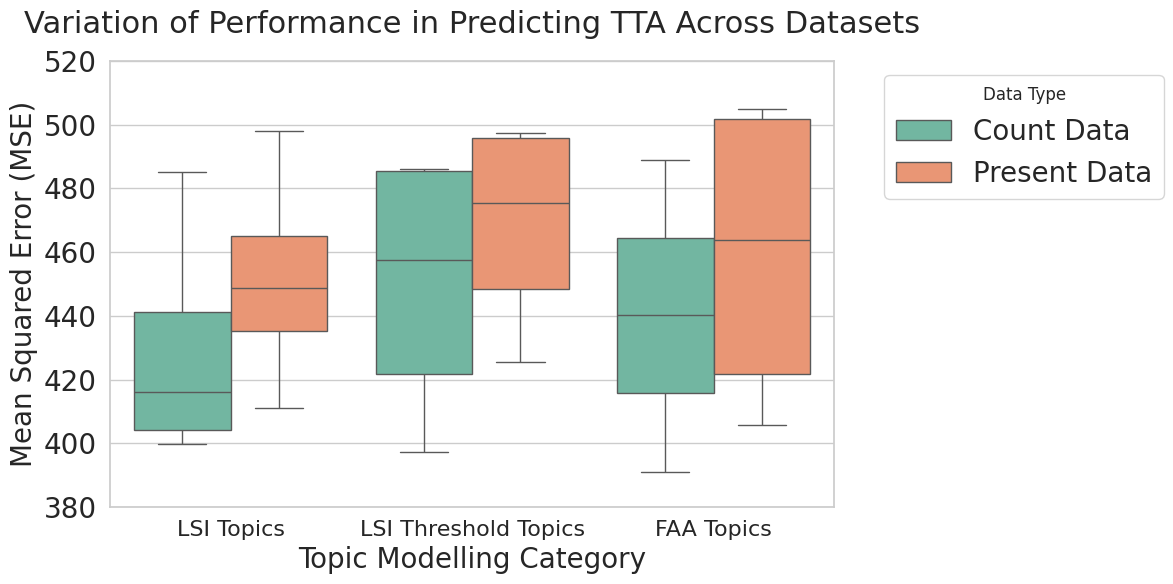

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'combined_model_results_reg.csv'
df = pd.read_csv(file_path)

mse_values = []
e
for index, row in df.iterrows():
    model = row['Model']

    # Loop through each dataset column and extract the MSE values
    for dataset in df.columns[1:]:
        metrics = row[dataset]
        mse = float(metrics.split('MSE: ')[1].split(' ')[0])

        mse_values.append({'Model': model, 'Dataset': dataset, 'MSE': mse})

mse_df = pd.DataFrame(mse_values)

# Filter out
mse_df = mse_df[~mse_df['Model'].isin(['Support Vector Regressor', 'Poisson Regression'])]

# Define dataset categories
dataset_mapping = {
    'Count Data, LSI Topic Modelling': 'LSI Topics',
    'Count Data, LSI Threshold Topic Modelling': 'LSI Threshold Topics',
    'Count Data, Adjective Analysis Topics': 'FAA Topics',
    'Present Data, LSI Topic Modelling': 'LSI Topics',
    'Present Data, LSI Threshold Topic Modelling': 'LSI Threshold Topics',
    'Present Data, Adjective Analysis Topics': 'FAA Topics'
}

mse_df['Category'] = mse_df['Dataset'].map(dataset_mapping)

# Categorize datasets into "Count Data" and "Present Data"
mse_df['Data_Type'] = mse_df['Dataset'].apply(lambda x: 'Count Data' if 'Count Data' in x else 'Present Data')

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Plot the data with the correct grouping
sns.boxplot(data=mse_df, x='Category', y='MSE', hue='Data_Type', palette="Set2")

# Set plot title and labels
#plt.title('Comparative MSE Across Models for Count Data and Present Data', fontsize=25)
plt.title('Variation of Performance in Predicting TTA Across Datasets',fontsize=22, pad=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=0, ha='center', fontsize=16)  # Keep the x-ticks horizontal and centered
plt.ylim(380, 520)  # Set y-axis limits
plt.xlabel('Topic Modelling Category',fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)

plt.legend(title='Data Type', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20)

plt.tight_layout()
plt.show()


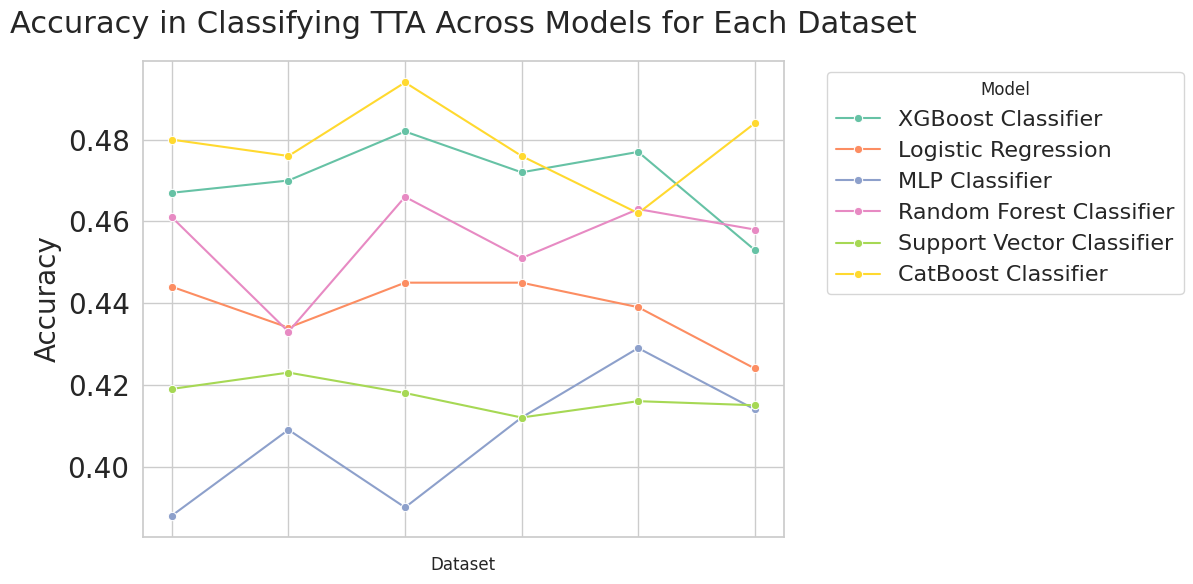

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'combined_model_results_class.csv'
df = pd.read_csv(file_path)

accuracy_values = []

for index, row in df.iterrows():
    model = row['Model']

    # Loop through each dataset column and extract the Accuracy values
    for dataset in df.columns[1:]:
        metrics = row[dataset]
        accuracy = float(metrics.split('Accuracy: ')[1].split(' ')[0])

        accuracy_values.append({'Model': model, 'Dataset': dataset, 'Accuracy': accuracy})

accuracy_df = pd.DataFrame(accuracy_values)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plotting lines for each dataset
sns.lineplot(data=accuracy_df, x='Dataset', y='Accuracy', hue='Model', marker='o', palette="Set2")

plt.title('Accuracy in Classifying TTA Across Models for Each Dataset', fontsize=22, pad=20)
plt.xticks(rotation=45, ha='right')
#plt.xlabel('Dataset')
plt.ylabel('Accuracy', fontsize=20)
plt.yticks(fontsize=20)

plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.gca().set_xticklabels([])

plt.tight_layout()
plt.show()


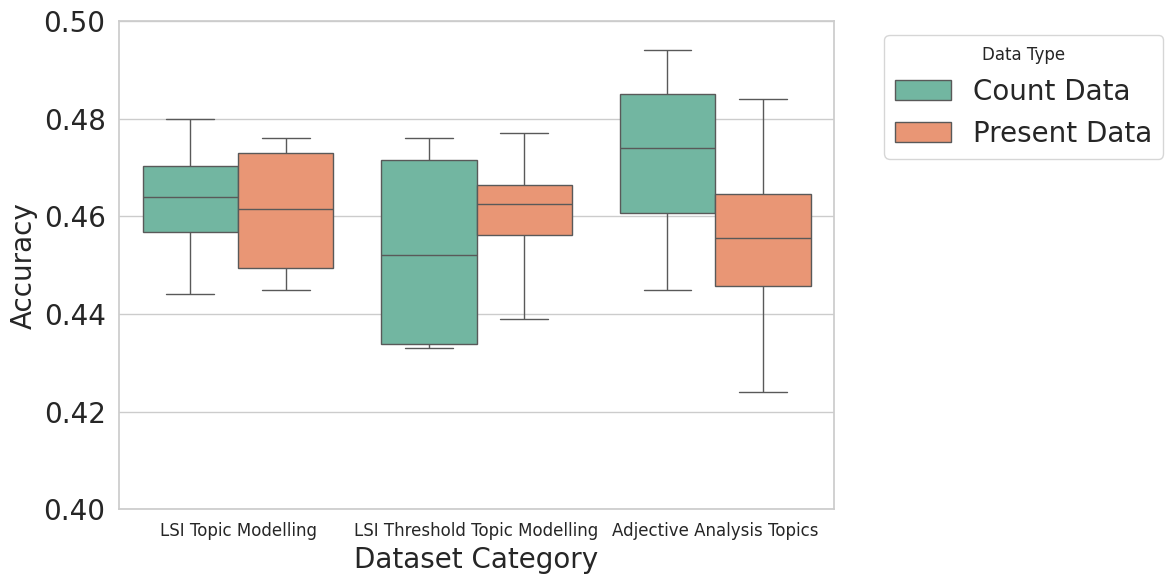

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'combined_model_results_class.csv'
df = pd.read_csv(file_path)

accuracy_values = []

for index, row in df.iterrows():
    model = row['Model']

    # Loop through each dataset column and extract the Accuracy values
    for dataset in df.columns[1:]:
        metrics = row[dataset]
        accuracy = float(metrics.split('Accuracy: ')[1].split(' ')[0])

        accuracy_values.append({'Model': model, 'Dataset': dataset, 'Accuracy': accuracy})

accuracy_df = pd.DataFrame(accuracy_values)

accuracy_df = accuracy_df[~accuracy_df['Model'].isin(['Support Vector Classifier', 'Poisson Classifier', 'MLP Classifier'])]

dataset_mapping = {
    'Count Data, LSI Topic Modelling': 'LSI Topic Modelling',
    'Count Data, LSI Threshold Topic Modelling': 'LSI Threshold Topic Modelling',
    'Count Data, Adjective Analysis Topics': 'Adjective Analysis Topics',
    'Present Data, LSI Topic Modelling': 'LSI Topic Modelling',
    'Present Data, LSI Threshold Topic Modelling': 'LSI Threshold Topic Modelling',
    'Present Data, Adjective Analysis Topics': 'Adjective Analysis Topics'
}

# Map datasets to broader categories
accuracy_df['Category'] = accuracy_df['Dataset'].map(dataset_mapping)

# Categorize datasets into "Count Data" and "Present Data"
accuracy_df['Data_Type'] = accuracy_df['Dataset'].apply(lambda x: 'Count Data' if 'Count Data' in x else 'Present Data')

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.boxplot(data=accuracy_df, x='Category', y='Accuracy', hue='Data_Type', palette="Set2", whis=2.0)

plt.yticks(fontsize=20)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.ylim(0.4, 0.5)
plt.xlabel('Dataset Category', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.legend(title='Data Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)

plt.tight_layout()
plt.show()
